In [128]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from mlmicrophysics.models import DenseNeuralNetwork
from sklearn.ensemble import RandomForestClassifier
from mlmicrophysics.explain import partial_dependence_2d
from mlmicrophysics.data import subset_data_files_by_date, log10_transform, neg_log10_transform, assemble_data_files
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler
from sklearn.metrics import r2_score, confusion_matrix, mean_squared_error
from keras.models import save_model
import yaml
from matplotlib.colors import LogNorm
scalers = {"MinMaxScaler": MinMaxScaler,
           "MaxAbsScaler": MaxAbsScaler,
           "StandardScaler": StandardScaler,
           "RobustScaler": RobustScaler}
transforms = {"log10_transform": log10_transform,
              "neg_log10_transform": neg_log10_transform}

# Data Loading

In [3]:
#path = "/glade/scratch/dgagne/cam_mp_files_run2_csv/"
path = "/Users/dgagne/data/cam_mp_files_run2_csv/"
train_files, val_files, test_files = subset_data_files_by_date(path, ".csv", train_date_start=0, train_date_end=8000, 
                                                               test_date_start=8100, test_date_end=16000)

[    0   123   246   369   492   615   738   861   984  1107  1230  1353
  1476  1599  1722  1845  1968  2091  2214  2337  2460  2583  2706  2829
  2952  3075  3198  3321  3444  3567  3690  3813  3936  4059  4182  4305
  4428  4551  4674  4797  4920  5043  5166  5289  5412  5535  5658  5781
  5904  6027  6150  6273  6396  6519  6642  6765  6888  7011  7134  7257
  7380  7503  7626  7749  7872  7995  8118  8241  8364  8487  8610  8733
  8856  8979  9102  9225  9348  9471  9594  9717  9840  9963 10086 10209
 10332 10455 10578 10701 10824 10947 11070 11193 11316 11439 11562 11685
 11808 11931 12054 12177 12300 12423 12546 12669 12792 12915 13038 13161
 13284 13407 13530 13653 13776 13899 14022 14145 14268 14391 14514 14637
 14760 14883 15006 15129 15252 15375 15498 15621 15744 15867 15990 16113
 16236 16359 16482 16605 16728 16851 16974 17097 17220 17343 17466]


In [14]:
input_transforms_yaml = """
  temperature: log10_transform
  pressure: log10_transform
  RHO_CLUBB_lev: log10_transform
  RHO_CLUBB_top: log10_transform
  RHO_CLUBB_bottom: log10_transform
  QC_TAU_in: log10_transform
  NC_TAU_in: log10_transform
  QR_TAU_in: log10_transform
  NR_TAU_in: log10_transform
  """
output_transforms_yaml = """
  qctend_TAU:
    0: [">=", -1e-15, "zero_transform", "None"]
    1: ["<", -1e-15, "neg_log10_transform", "StandardScaler"]
  qrtend_TAU:
    0: ["<=", 1e-15, "zero_transform", "None"]
    1: [">", 1e-15, "log10_transform", "StandardScaler"]
  nctend_TAU:
    0: [">=", -1e-15, "zero_transform", "None"]
    1: ["<", -1e-15, "neg_log10_transform", "StandardScaler"]
  nrtend_TAU:
    -1: ["<", 0, "neg_log10_transform", "StandardScaler"]
    0: ["==", 0, "zero_transform", "None"]
    1: [">", 0, "log10_transform", "StandardScaler"]
  qctend_MG2:
    0: [">=", -1e-15, "zero_transform", "None"]
    1: ["<", -1e-15, "neg_log10_transform", "StandardScaler"]
  qrtend_MG2:
    0: ["<=", 1e-15, "zero_transform", "None"]
    1: [">", 1e-15, "log10_transform", "StandardScaler"]
  nctend_MG2:
    0: [">=", -1e-15, "zero_transform", "None"]
    1: ["<", -1e-15, "neg_log10_transform", "StandardScaler"]
  nrtend_MG2:
    -1: ["<", 0, "neg_log10_transform", "StandardScaler"]
    0: ["==", 0, "zero_transform", "None"]
    1: [">", 0, "log10_transform", "StandardScaler"]
"""
input_transforms = yaml.load(input_transforms_yaml)
output_transforms = yaml.load(output_transforms_yaml)

In [15]:
input_transforms

{'temperature': 'log10_transform',
 'pressure': 'log10_transform',
 'RHO_CLUBB_lev': 'log10_transform',
 'RHO_CLUBB_top': 'log10_transform',
 'RHO_CLUBB_bottom': 'log10_transform',
 'QC_TAU_in': 'log10_transform',
 'NC_TAU_in': 'log10_transform',
 'QR_TAU_in': 'log10_transform',
 'NR_TAU_in': 'log10_transform'}

In [156]:
input_scaler = StandardScaler()
input_cols = ["pressure", "temperature", "RHO_CLUBB_lev", "RHO_CLUBB_top", "RHO_CLUBB_bottom",
             "QC_TAU_in", "NC_TAU_in", "QR_TAU_in", "NR_TAU_in",]
output_cols = ["qctend_TAU", "qrtend_TAU", "nctend_TAU", "nrtend_TAU", 
               "qctend_MG2", "qrtend_MG2", "nctend_MG2", "nrtend_MG2"]

scaled_input_train,\
    labels_train,\
    transformed_out_train,\
    scaled_out_train,\
    output_scalers =  assemble_data_files(train_files, input_cols, output_cols, input_transforms,
                                          output_transforms, input_scaler, subsample=0.01)

/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_000123.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_000246.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_000492.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_000615.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_000861.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_000984.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_001230.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_001353.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_001599.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_001722.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_001968.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_002091.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_002337.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_002460.csv
/Users/dgagne/data/cam_mp_files_ru

In [158]:
scaled_input_test,\
    labels_test,\
    transformed_out_test,\
    scaled_out_test,\
    output_scalers_test = assemble_data_files(test_files, input_cols, output_cols, input_transforms,
                                             output_transforms, input_scaler, output_scalers=output_scalers,
                                             subsample=0.01)

/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_008118.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_008241.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_008364.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_008487.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_008610.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_008733.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_008856.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_008979.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_009102.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_009225.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_009348.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_009471.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_009594.csv
/Users/dgagne/data/cam_mp_files_run2_csv/cam_mp_data_run2_009717.csv
/Users/dgagne/data/cam_mp_files_ru

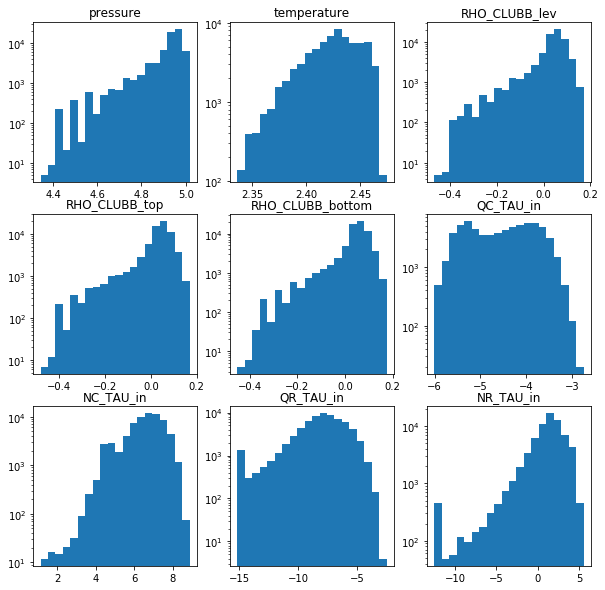

In [242]:
fig, axes = plt.subplots(3,3, figsize=(10, 10))
transformed_input_train = pd.DataFrame(input_scaler.inverse_transform(scaled_input_train), columns=input_cols)
for a, ax in enumerate(axes.ravel()):
    ax.set_yscale("log")
    ax.hist(transformed_input_train[input_cols[a]], bins=20)
    ax.set_title(input_cols[a])

# Model Training

In [244]:
dnn_qr_class = DenseNeuralNetwork(hidden_layers=6, hidden_neurons=30,
                                  inputs=len(input_cols), outputs=2,
                                  loss="categorical_crossentropy",
                                  output_activation="softmax",
                                  activation="relu", epochs=60,
                                  batch_size=256, verbose=1, lr=0.001, classifier=True)
dnn_qr = DenseNeuralNetwork(hidden_layers=6, hidden_neurons=30, 
                         inputs=len(input_cols), outputs=1, 
                         loss="mse", activation="selu", epochs=60, 
                         batch_size=256, verbose=1, lr=0.001)
dnn_nc = DenseNeuralNetwork(hidden_layers=6, hidden_neurons=30, 
                         inputs=len(input_cols), outputs=1, 
                         loss="mse", activation="selu", epochs=60, 
                         batch_size=256, verbose=1, l2_weight=0, lr=0.001)



In [245]:
dnn_qr_class.fit(scaled_input_train, labels_train["qrtend_TAU"])

Epoch 1/60
67105/67105 [==============================] - 2s 29us/step - loss: 1.0312
Epoch 2/60
67105/67105 [==============================] - 1s 9us/step - loss: 0.3944
Epoch 3/60
67105/67105 [==============================] - 1s 9us/step - loss: 0.3065
Epoch 4/60
67105/67105 [==============================] - 1s 10us/step - loss: 0.2744
Epoch 5/60
67105/67105 [==============================] - 1s 9us/step - loss: 0.2530
Epoch 6/60
67105/67105 [==============================] - 1s 10us/step - loss: 0.2398
Epoch 7/60
67105/67105 [==============================] - 1s 10us/step - loss: 0.2338
Epoch 8/60
67105/67105 [==============================] - 1s 10us/step - loss: 0.2276
Epoch 9/60
67105/67105 [==============================] - 1s 10us/step - loss: 0.2231
Epoch 10/60
67105/67105 [==============================] - 1s 10us/step - loss: 0.2206
Epoch 11/60
67105/67105 [==============================] - 1s 9us/step - loss: 0.2182
Epoch 12/60
67105/67105 [==============================]

In [246]:
dnn_qr.fit(scaled_input_train.loc[labels_train["qrtend_TAU"] == 1], 
           scaled_out_train.loc[labels_train["qrtend_TAU"] == 1, "qrtend_TAU"].values)

Epoch 1/60
48038/48038 [==============================] - 2s 42us/step - loss: 1.5601
Epoch 2/60
48038/48038 [==============================] - 1s 14us/step - loss: 1.0071
Epoch 3/60
48038/48038 [==============================] - 1s 13us/step - loss: 0.6803
Epoch 4/60
48038/48038 [==============================] - 1s 13us/step - loss: 0.4820
Epoch 5/60
48038/48038 [==============================] - 1s 14us/step - loss: 0.3636
Epoch 6/60
48038/48038 [==============================] - 1s 15us/step - loss: 0.2869
Epoch 7/60
48038/48038 [==============================] - 1s 13us/step - loss: 0.2373
Epoch 8/60
48038/48038 [==============================] - 1s 14us/step - loss: 0.2036
Epoch 9/60
48038/48038 [==============================] - 1s 14us/step - loss: 0.1824
Epoch 10/60
48038/48038 [==============================] - 1s 13us/step - loss: 0.1661
Epoch 11/60
48038/48038 [==============================] - 1s 14us/step - loss: 0.1520
Epoch 12/60
48038/48038 [===========================

In [162]:
dnn_nc.fit(scaled_input_train, scaled_out_train.loc[:, "nctend_TAU"])

Epoch 1/30
67105/67105 [==============================] - 2s 26us/step - loss: 0.0842
Epoch 2/30
67105/67105 [==============================] - 1s 11us/step - loss: 0.0184
Epoch 3/30
67105/67105 [==============================] - 1s 11us/step - loss: 0.0131
Epoch 4/30
67105/67105 [==============================] - 1s 11us/step - loss: 0.0108
Epoch 5/30
67105/67105 [==============================] - 1s 11us/step - loss: 0.0095
Epoch 6/30
67105/67105 [==============================] - 1s 12us/step - loss: 0.0091
Epoch 7/30
67105/67105 [==============================] - 1s 12us/step - loss: 0.0084
Epoch 8/30
67105/67105 [==============================] - 1s 14us/step - loss: 0.0083
Epoch 9/30
67105/67105 [==============================] - 1s 14us/step - loss: 0.0079
Epoch 10/30
67105/67105 [==============================] - 1s 12us/step - loss: 0.0077
Epoch 11/30
67105/67105 [==============================] - 1s 11us/step - loss: 0.0073
Epoch 12/30
67105/67105 [===========================

In [248]:
save_model(dnn_nc.model, "dnn_nc.h5")
save_model(dnn_qr.model, "dnn_qr.h5")

AttributeError: 'NoneType' object has no attribute 'get_config'

In [164]:
dnn_nr_class = DenseNeuralNetwork(hidden_layers=6, hidden_neurons=30,
                                  inputs=len(input_cols), outputs=3,
                                  loss="categorical_crossentropy",
                                  output_activation="softmax",
                                  activation="relu", epochs=30,
                                  batch_size=256, verbose=1, lr=0.005, classifier=True)
dnn_nr_class.fit(scaled_input_train, labels_train["nrtend_TAU"])

Epoch 1/30
67105/67105 [==============================] - 2s 23us/step - loss: 1.3484
Epoch 2/30
67105/67105 [==============================] - 1s 9us/step - loss: 0.6181
Epoch 3/30
67105/67105 [==============================] - 1s 9us/step - loss: 0.5002
Epoch 4/30
67105/67105 [==============================] - 1s 9us/step - loss: 0.4548
Epoch 5/30
67105/67105 [==============================] - 1s 12us/step - loss: 0.4301
Epoch 6/30
67105/67105 [==============================] - 1s 11us/step - loss: 0.4154
Epoch 7/30
67105/67105 [==============================] - 1s 13us/step - loss: 0.4035
Epoch 8/30
67105/67105 [==============================] - 1s 10us/step - loss: 0.3964
Epoch 9/30
67105/67105 [==============================] - 1s 9us/step - loss: 0.3885
Epoch 10/30
67105/67105 [==============================] - 1s 13us/step - loss: 0.3843
Epoch 11/30
67105/67105 [==============================] - 1s 11us/step - loss: 0.3800
Epoch 12/30
67105/67105 [==============================]

In [165]:
test_nr_sign = dnn_nr_class.predict(scaled_input_test)

In [166]:

confusion_matrix(labels_test["nrtend_TAU"].values, test_nr_sign)

array([[15827,   262,  1400],
       [  104, 24461,  3555],
       [  742,  1528, 50127]])

In [179]:
confusion_matrix(labels_test["qrtend_TAU"].values, dnn_qr_class.predict(scaled_input_test))

array([[24108,  4012],
       [ 1221, 68665]])

In [167]:
nr_pos_net = DenseNeuralNetwork(hidden_layers=6, hidden_neurons=30, 
                         inputs=len(input_cols), outputs=1, 
                         loss="mse", activation="selu", epochs=30, 
                         batch_size=256, verbose=1, l2_weight=0, lr=0.005)
nr_neg_net = DenseNeuralNetwork(hidden_layers=6, hidden_neurons=30, 
                         inputs=len(input_cols), outputs=1, 
                         loss="mse", activation="selu", epochs=30, 
                         batch_size=256, verbose=1, l2_weight=0, lr=0.005)

In [168]:
pos_sub = labels_train["nrtend_TAU"] == 1
neg_sub = labels_train["nrtend_TAU"] == -1
nr_pos_net.fit(scaled_input_train.loc[pos_sub], scaled_out_train.loc[pos_sub, "nrtend_TAU"])
nr_neg_net.fit(scaled_input_train.loc[neg_sub], scaled_out_train.loc[neg_sub, "nrtend_TAU"])

Epoch 1/30
36161/36161 [==============================] - 1s 40us/step - loss: 0.4927
Epoch 2/30
36161/36161 [==============================] - 0s 12us/step - loss: 0.1927
Epoch 3/30
36161/36161 [==============================] - 0s 12us/step - loss: 0.1409
Epoch 4/30
36161/36161 [==============================] - 0s 12us/step - loss: 0.1103
Epoch 5/30
36161/36161 [==============================] - 0s 12us/step - loss: 0.0915
Epoch 6/30
36161/36161 [==============================] - 0s 13us/step - loss: 0.0819
Epoch 7/30
36161/36161 [==============================] - 0s 12us/step - loss: 0.0787
Epoch 8/30
36161/36161 [==============================] - 0s 12us/step - loss: 0.0737
Epoch 9/30
36161/36161 [==============================] - 1s 16us/step - loss: 0.0728
Epoch 10/30
36161/36161 [==============================] - 0s 12us/step - loss: 0.0709
Epoch 11/30
36161/36161 [==============================] - 0s 13us/step - loss: 0.0710
Epoch 12/30
36161/36161 [===========================

In [169]:
nr_pred_values = np.zeros(scaled_input_test.shape[0])
nr_pred_values[test_nr_sign > 0] = 10 ** output_scalers["nrtend_TAU"][1].inverse_transform(nr_pos_net.predict(scaled_input_test[test_nr_sign > 0]).ravel())
nr_pred_values[test_nr_sign < 0] = -10 ** output_scalers["nrtend_TAU"][-1].inverse_transform(nr_neg_net.predict(scaled_input_test[test_nr_sign < 0]).ravel())

(array([5.4600e+02, 1.1108e+04, 2.3703e+04, 2.2619e+04, 1.1133e+04,
        7.7400e+02, 3.0000e+00, 0.0000e+00, 0.0000e+00, 2.8120e+04]),
 array([-14.46279136, -13.01651222, -11.57023309, -10.12395395,
         -8.67767482,  -7.23139568,  -5.78511654,  -4.33883741,
         -2.89255827,  -1.44627914,   0.        ]),
 <a list of 10 Patch objects>)

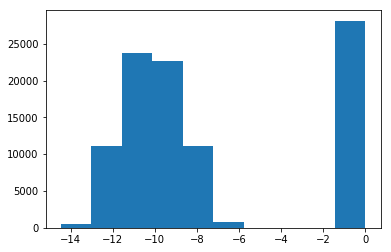

In [181]:
plt.hist(transformed_out_test["qrtend_TAU"])

In [200]:
pred_tendencies = pd.DataFrame(0, index=scaled_out_test.index, columns=output_cols[1:4], dtype=float)
qr_class_preds = dnn_qr_class.predict(scaled_input_test)
pred_tendencies.loc[:, "qrtend_TAU"] = output_scalers["qrtend_TAU"][1].inverse_transform(dnn_qr.predict(scaled_input_test))
pred_tendencies.loc[:, "nctend_TAU"] = output_scalers["nctend_TAU"][1].inverse_transform(dnn_nc.predict(scaled_input_test))
pred_tendencies.loc[:, "nrtend_TAU"] = nr_pred_values


# Partial Dependence Plots

In [171]:
def partial_dependence_1d(x, model, var_index, var_vals):
    """
    Calculate how the mean prediction of an ML model varies if one variable's value is fixed across all input
    examples.

    Args:
        x: array of input variables
        model: scikit-learn style model object
        var_index: column index of the variable being investigated
        var_vals: values of the input variable that are fixed.

    Returns:
        Array of partial dependence values.
    """
    partial_dependence = np.zeros(var_vals.shape)
    x_copy = np.copy(x)
    for v, var_val in enumerate(var_vals):
        x_copy[:, var_index] = var_val
        partial_dependence[v] = model.predict(x_copy).mean()
    return partial_dependence

In [172]:
pd_bins = 20
pd_vals = np.zeros((len(input_cols), pd_bins))
for v, var in enumerate(input_cols):
    print(var, scaled_input_train[var].min(), scaled_input_train[var].max())
    pd_vals[v] = np.linspace( scaled_input_train[var].min(), scaled_input_train[var].max(), pd_bins)

pressure -6.241972785575437 1.1535710325719295
temperature -3.3668801927425656 1.9607122973218234
RHO_CLUBB_lev -6.443336263399296 1.8076514501984342
RHO_CLUBB_top -6.057703029205403 1.7522447846003062
RHO_CLUBB_bottom -6.848920739021809 1.8895594569487353
QC_TAU_in -2.1000053237501897 2.524446462538485
NC_TAU_in -5.5946476131719685 2.4165050133775146
QR_TAU_in -3.351652915430671 2.628850364671379
NR_TAU_in -5.8413948786478045 1.9132963687884883


In [173]:
pd_output_qr = np.zeros((len(input_cols), pd_vals.shape[1]))
for v, var in enumerate(input_cols):
    print(v, var)
    pd_output_qr[v] = partial_dependence_1d(scaled_input_train, dnn_qr, v, pd_vals[v])

0 pressure
1 temperature
2 RHO_CLUBB_lev
3 RHO_CLUBB_top
4 RHO_CLUBB_bottom
5 QC_TAU_in
6 NC_TAU_in
7 QR_TAU_in
8 NR_TAU_in


In [219]:
pd_output_nc = np.zeros((len(input_cols), pd_vals.shape[1]))
for v, var in enumerate(input_cols):
    print(v, var)
    pd_output_nc[v] = partial_dependence_1d(scaled_input_train, dnn_nc, v, pd_vals[v])

0 pressure
1 temperature
2 RHO_CLUBB_lev
3 RHO_CLUBB_top
4 RHO_CLUBB_bottom
5 QC_TAU_in
6 NC_TAU_in
7 QR_TAU_in
8 NR_TAU_in


In [118]:
pd_output_nr_pos = np.zeros((len(input_cols), pd_vals.shape[1]))
for v, var in enumerate(input_cols):
    print(v, var)
    pd_output_nr_pos[v] = partial_dependence_1d(scaled_input_train, nr_pos_net, v, pd_vals[v])

0 pressure
1 temperature
2 RHO_CLUBB_lev
3 RHO_CLUBB_top
4 RHO_CLUBB_bottom
5 QC_TAU_in
6 NC_TAU_in
7 QR_TAU_in
8 NR_TAU_in


In [119]:
pd_output_nr_neg = np.zeros((len(input_cols), pd_vals.shape[1]))
for v, var in enumerate(input_cols):
    print(v, var)
    pd_output_nr_neg[v] = partial_dependence_1d(scaled_input_train, nr_neg_net, v, pd_vals[v])

0 pressure
1 temperature
2 RHO_CLUBB_lev
3 RHO_CLUBB_top
4 RHO_CLUBB_bottom
5 QC_TAU_in
6 NC_TAU_in
7 QR_TAU_in
8 NR_TAU_in


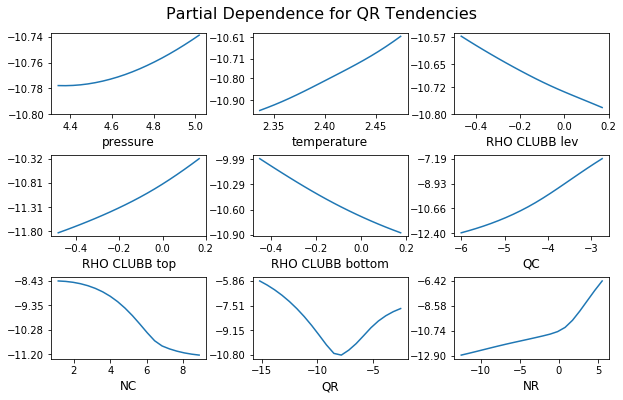

In [217]:
pd_unscaled = input_scaler.inverse_transform(pd_vals.T)
pd_unscaled_qr = output_scalers["qrtend_TAU"][1].inverse_transform(pd_output_qr)
fig, axes = plt.subplots(3, 3, figsize=(10, 6), sharey=False)
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for a, ax in enumerate(axes.ravel()):
    ax.plot(pd_unscaled[:, a], pd_unscaled_qr[a])
    ax.set_xlabel(input_cols[a].replace("_TAU_in", "").replace("_", " "), fontsize=12)
    ax.set_yticks(np.round(np.linspace(np.round(pd_unscaled_qr[a].min(), 1), 
                                       np.round(pd_unscaled_qr[a].max(), 2), 4), 2))
fig.suptitle("Partial Dependence for QR Tendencies", fontsize=16, y=0.94)
plt.savefig("pdp_qr.png", dpi=200, bbox_inches="tight")

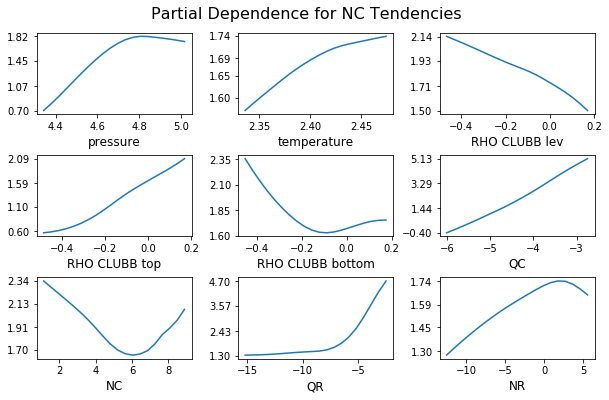

In [221]:
pd_unscaled = input_scaler.inverse_transform(pd_vals.T)
pd_unscaled_nc = output_scalers["nctend_TAU"][1].inverse_transform(pd_output_nc)

fig, axes = plt.subplots(3, 3, figsize=(10, 6), sharey=False)
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for a, ax in enumerate(axes.ravel()):
    ax.plot(pd_unscaled[:, a], pd_unscaled_nc[a])

    ax.set_xlabel(input_cols[a].replace("_TAU_in", "").replace("_", " "), fontsize=12)
    ax.set_yticks(np.round(np.linspace(np.round(pd_unscaled_nc[a].min(), 1), 
                                       np.round(pd_unscaled_nc[a].max(), 2), 4), 2))
fig.suptitle("Partial Dependence for NC Tendencies", fontsize=16, y=0.94)
plt.savefig("pdp_nc.png", dpi=200, bbox_inches="tight")

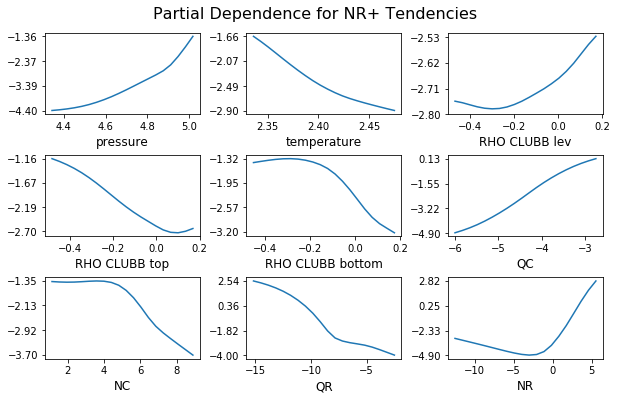

In [230]:
pd_unscaled = input_scaler.inverse_transform(pd_vals.T)
pd_unscaled_nr_pos = output_scalers["nrtend_TAU"][1].inverse_transform(pd_output_nr_pos)
pd_unscaled_nr_neg = output_scalers["nrtend_TAU"][-1].inverse_transform(pd_output_nr_neg)

fig, axes = plt.subplots(3, 3, figsize=(10, 6), sharey=False)
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for a, ax in enumerate(axes.ravel()):
        
    ax.plot(pd_unscaled[:, a], pd_unscaled_nr_pos[a], label="NR+")
    ax.set_xlabel(input_cols[a].replace("_TAU_in", "").replace("_", " "), fontsize=12)
    ax.set_yticks(np.round(np.linspace(np.round(pd_unscaled_nr_pos[a].min(), 1), 
                                       np.round(pd_unscaled_nr_pos[a].max(), 2), 4), 2))
fig.suptitle("Partial Dependence for NR+ Tendencies", fontsize=16, y=0.94)
plt.savefig("pdp_nr_pos.png", dpi=200, bbox_inches="tight")

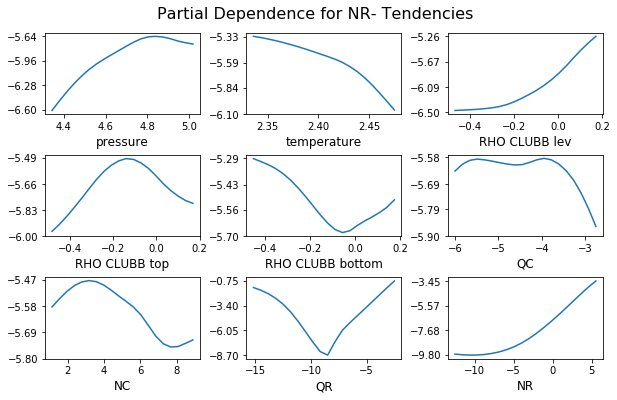

In [233]:
pd_unscaled = input_scaler.inverse_transform(pd_vals.T)
pd_unscaled_nr_pos = output_scalers["nrtend_TAU"][1].inverse_transform(pd_output_nr_pos)
pd_unscaled_nr_neg = output_scalers["nrtend_TAU"][-1].inverse_transform(pd_output_nr_neg)

fig, axes = plt.subplots(3, 3, figsize=(10, 6), sharey=False)
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for a, ax in enumerate(axes.ravel()):        
    ax.plot(pd_unscaled[:, a], pd_unscaled_nr_neg[a], label="NR-")

    ax.set_xlabel(input_cols[a].replace("_TAU_in", "").replace("_", " "), fontsize=12)
    ax.set_yticks(np.round(np.linspace(np.round(pd_unscaled_nr_neg[a].min(), 1), 
                                       np.round(pd_unscaled_nr_neg[a].max(), 2), 4), 2))
fig.suptitle("Partial Dependence for NR- Tendencies", fontsize=16, y=0.94)
plt.savefig("pdp_nr_neg.png", dpi=200, bbox_inches="tight")

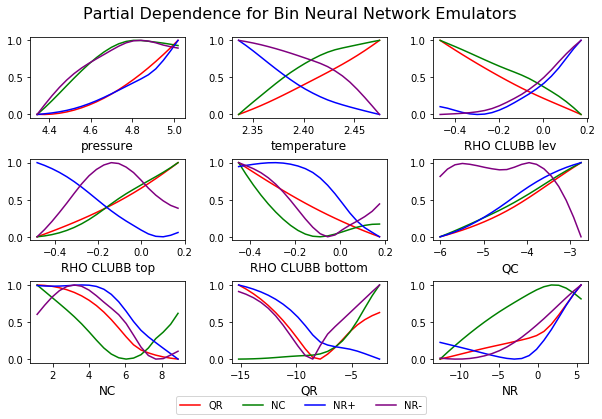

In [266]:
all_pd_out = [pd_output_qr, pd_output_nc, pd_output_nr_pos, pd_output_nr_neg]
pd_names = ["QR", "NC", "NR+", "NR-"]
colors = ['red', 'green', 'blue', 'purple']
fig, axes = plt.subplots(3, 3, figsize=(10, 6), sharey=False)
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for a, ax in enumerate(axes.ravel()):
    for o in range(len(all_pd_out)):
        ax.plot(pd_unscaled[:, a], 
                (all_pd_out[o][a] - all_pd_out[o][a].min()) / (all_pd_out[o][a].max() - all_pd_out[o][a].min()),
                color=colors[o])
    ax.set_xlabel(input_cols[a].replace("_TAU_in", "").replace("_", " "), fontsize=12)
plt.figlegend(pd_names, loc='lower center', ncol=4)
plt.suptitle("Partial Dependence for Bin Neural Network Emulators", y=0.95, fontsize=16)
plt.savefig("pdp_all.png", dpi=200, bbox_inches="tight")

In [175]:
pd_grid_nc = partial_dependence_2d(scaled_input_train, dnn_nc, 5, pd_vals[5], 6, pd_vals[6])

KeyboardInterrupt: 

In [ ]:
plt.contourf(pd_unscaled[:, 6], pd_unscaled[:, 5], pd_grid_nc, np.arange(-3, 3.5, .5), cmap="RdBu_r")
plt.xlabel(input_cols[6])
plt.ylabel(input_cols[5])
plt.colorbar()

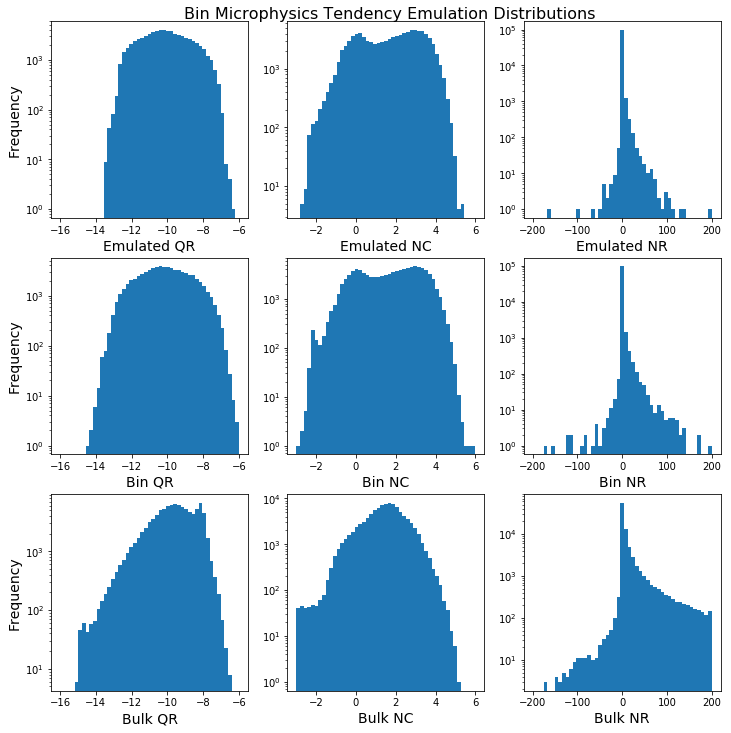

In [205]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
plt.subplots_adjust(0.03, 0.03, 0.96, 0.96, wspace=0.2)
all_bins = [np.linspace(-16, -6, 50), np.linspace(-3,6, 50), np.linspace(-200, 200, 50)]
axes[0, 0].hist(pred_tendencies.loc[labels_test["qrtend_TAU"] == 1, "qrtend_TAU"],
             bins=all_bins[0])
axes[0, 0].set_xlabel("Emulated QR", fontsize=14)
axes[0, 0].set_yscale("log")
axes[0, 1].hist(pred_tendencies.loc[:, "nctend_TAU"], 
            bins=all_bins[1])
axes[0, 1].set_yscale("log")
axes[0, 1].set_xlabel("Emulated NC", fontsize=14)
axes[0, 2].hist(pred_tendencies.loc[:, "nrtend_TAU"], 
             bins=all_bins[2])
axes[0, 2].set_yscale("log")
axes[0, 2].set_xlabel("Emulated NR", fontsize=14)
axes[1, 0].hist(transformed_out_test["qrtend_TAU"],
             bins=all_bins[0])
axes[1, 0].set_yscale("log")
axes[1, 0].set_xlabel("Bin QR", fontsize=14)
axes[1, 1].hist(transformed_out_test["nctend_TAU"], 
            bins=all_bins[1])
axes[1, 1].set_yscale("log")
axes[1, 1].set_xlabel("Bin NC", fontsize=14)
original_out_test = np.zeros(transformed_out_test["nrtend_TAU"].size)
original_out_test[labels_test["nrtend_TAU"] > 0] = 10 ** transformed_out_test.loc[labels_test["nrtend_TAU"] > 0, 
                                                                                  "nrtend_TAU"]
original_out_test[labels_test["nrtend_TAU"] < 0] = -10 ** transformed_out_test.loc[labels_test["nrtend_TAU"] < 0, 
                                                                                  "nrtend_TAU"]
axes[1, 2].hist(original_out_test, 
             bins=all_bins[2])
axes[1, 2].set_yscale("log")
axes[1, 2].set_xlabel("Bin NR", fontsize=14)
axes[2, 0].hist(transformed_out_test["qrtend_MG2"],
               bins=all_bins[0])
axes[2, 0].set_yscale("log")
axes[2, 0].set_xlabel("Bulk QR", fontsize=14)
axes[2, 1].hist(transformed_out_test["nctend_MG2"], 
            bins=all_bins[1])
axes[2, 1].set_yscale("log")
axes[2, 1].set_xlabel("Bulk NC", fontsize=14)
original_out_test = np.zeros(transformed_out_test["nrtend_MG2"].size)
original_out_test[labels_test["nrtend_MG2"] > 0] = 10 ** transformed_out_test.loc[labels_test["nrtend_MG2"] > 0, 
                                                                                  "nrtend_MG2"]
original_out_test[labels_test["nrtend_MG2"] < 0] = -10 ** transformed_out_test.loc[labels_test["nrtend_MG2"] < 0, 
                                                                                  "nrtend_MG2"]
axes[2, 2].hist(original_out_test, 
             bins=all_bins[2])
axes[2, 2].set_yscale("log")
axes[2, 2].set_xlabel("Bulk NR", fontsize=14)
axes[0, 0].set_ylabel("Frequency", fontsize=14)
axes[1, 0].set_ylabel("Frequency", fontsize=14)
axes[2, 0].set_ylabel("Frequency", fontsize=14)
fig.suptitle("Bin Microphysics Tendency Emulation Distributions", y=0.98, fontsize=16)
plt.savefig("nn_bin_hist.png", dpi=200, bbox_inches="tight")

In [192]:
transformed_out_test.loc[transformed_out_test["qrtend_TAU"] < 0, "qrtend_TAU"]

0       -11.758728
3       -10.194901
4        -9.364924
9       -13.402578
13      -10.557598
14      -10.289907
16      -11.657069
17       -9.239288
18      -11.521441
19       -9.431602
20       -9.261008
22       -9.468618
23       -9.423866
26       -9.049459
28       -8.015106
29      -10.582174
30       -9.777781
31       -9.862971
34      -10.963488
35      -10.082544
37      -11.568765
38      -11.309095
39       -9.847729
40      -11.847333
42      -10.144269
43      -10.780347
45       -8.915291
48      -10.692613
49      -10.577247
51       -8.435481
           ...    
97976    -8.933398
97977    -8.872843
97978   -10.252928
97979    -9.869181
97980    -9.822349
97981    -8.684698
97982   -10.227599
97983   -11.365665
97984    -9.880169
97985    -9.555189
97986   -11.378923
97987   -10.096209
97988   -10.491423
97989   -11.941214
97990   -10.785126
97991   -13.017644
97992   -13.018031
97993   -13.017515
97994   -13.020953
97995   -13.021616
97996   -13.021560
97997   -11.

In [206]:
rmses = np.zeros(3)
rmses[0] = np.sqrt(mean_squared_error(transformed_out_test.loc[transformed_out_test["qrtend_TAU"] < 0, "qrtend_TAU"], 
                                      pred_tendencies.loc[transformed_out_test["qrtend_TAU"] < 0, "qrtend_TAU"]))
rmses[1] = np.sqrt(mean_squared_error(transformed_out_test["nctend_TAU"], 
                                      pred_tendencies.loc[:, "nctend_TAU"]))
original_out_test = np.zeros(transformed_out_test["nrtend_TAU"].size)
original_out_test[labels_test["nrtend_TAU"] > 0] = 10 ** transformed_out_test.loc[labels_test["nrtend_TAU"] > 0, 
                                                                                  "nrtend_TAU"]
original_out_test[labels_test["nrtend_TAU"] < 0] = -10 ** transformed_out_test.loc[labels_test["nrtend_TAU"] < 0, 
                                                                                  "nrtend_TAU"]
rmses[2] = np.sqrt(mean_squared_error(original_out_test, 
                                      pred_tendencies.loc[:, "nrtend_TAU"]))
r2s = np.zeros(3)
r2s[0] = r2_score(transformed_out_test.loc[transformed_out_test["qrtend_TAU"] < 0, "qrtend_TAU"], 
                  pred_tendencies.loc[transformed_out_test["qrtend_TAU"] < 0, "qrtend_TAU"])
r2s[1] = r2_score(transformed_out_test["nctend_TAU"], 
                  pred_tendencies.loc[:, "nctend_TAU"])
r2s[2] = r2_score(original_out_test, 
                  pred_tendencies.loc[:, "nrtend_TAU"])

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


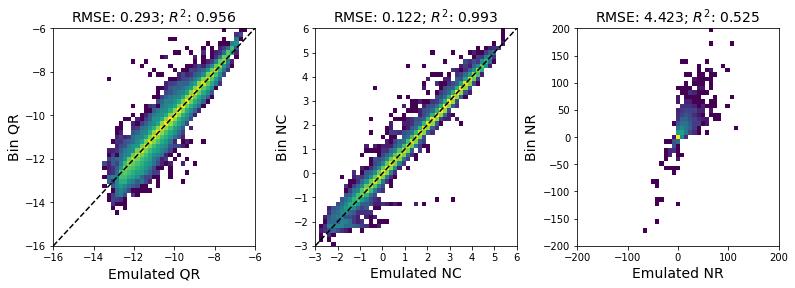

In [208]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
plt.subplots_adjust(wspace=0.3)
axes[0].hist2d(pred_tendencies["qrtend_TAU"], 
               transformed_out_test["qrtend_TAU"],
               cmin=1, bins=all_bins[0], norm=LogNorm())
axes[0].set_xlabel("Emulated QR", fontsize=14)
axes[0].set_ylabel("Bin QR", fontsize=14)
axes[1].set_xticks(np.arange(-16, 7))
axes[1].set_yticks(np.arange(-16, 7))
axes[0].plot(np.arange(-16, 7),np.arange(-16, 7), 'k--')
axes[0].set_title("RMSE: {0:0.3f}; $R^2$: {1:0.3f}".format(rmses[0], r2s[0]), fontsize=14)
axes[1].hist2d(pred_tendencies["nctend_TAU"], 
               transformed_out_test["nctend_TAU"],
               cmin=1, bins=all_bins[1], norm=LogNorm())
axes[1].set_xlabel("Emulated NC", fontsize=14)
axes[1].set_ylabel("Bin NC", fontsize=14)
axes[1].set_title("RMSE: {0:0.3f}; $R^2$: {1:0.3f}".format(rmses[1], r2s[1]), fontsize=14)
axes[1].set_xticks(np.arange(-3, 7))
axes[1].set_yticks(np.arange(-3, 7))
axes[1].plot(np.arange(-3, 7),np.arange(-3, 7), 'k--')
axes[2].hist2d(pred_tendencies["nrtend_TAU"], 
               original_out_test,
               cmin=1, bins=all_bins[2], norm=LogNorm())
axes[2].set_xlabel("Emulated NR", fontsize=14)
axes[2].set_ylabel("Bin NR", fontsize=14)
axes[2].set_title("RMSE: {0:0.3f}; $R^2$: {1:0.3f}".format(rmses[2], r2s[2]), fontsize=14)
#axes[2].set_xticks(np.arange(-400, 500, 100))
#axes[2].set_yticks(np.arange(-400, 500, 100))
#axes[2].plot(np.arange(-400, 500, 100),np.arange(-400, 500, 100), 'k--')
plt.savefig("nn_bin_hist2d.png", dpi=200, bbox_inches="tight")

In [93]:
def inverse_nr(nr_labels, nr_vals):
    inverse_vals = np.zeros(nr_vals.size)
    inverse_vals[nr_labels > 0] = 10 ** nr_vals[nr_labels > 0]
    inverse_vals[nr_labels < 0] = -10 ** nr_vals[nr_labels < 0]
    return inverse_vals

In [95]:
rmses_bulk = np.zeros(3)
rmses_bulk[0] = np.sqrt(mean_squared_error(transformed_out_test["qrtend_TAU"], 
                                           transformed_out_test["qrtend_MG2"]))
rmses_bulk[1] = np.sqrt(mean_squared_error(transformed_out_test["nctend_TAU"], 
                                           transformed_out_test["nctend_MG2"]))
rmses_bulk[2] = np.sqrt(mean_squared_error(inverse_nr(labels_test["nrtend_TAU"], transformed_out_test["nrtend_TAU"]), 
                                           inverse_nr(labels_test["nrtend_MG2"], transformed_out_test["nrtend_MG2"])))
r2s_bulk = np.zeros(3)
r2s_bulk[0] = r2_score(transformed_out_test["qrtend_TAU"], 
                       transformed_out_test["qrtend_MG2"])
r2s_bulk[1] = r2_score(transformed_out_test["nctend_TAU"], 
                       transformed_out_test["nctend_MG2"])
r2s_bulk[2] = r2_score(inverse_nr(labels_test["nrtend_TAU"], transformed_out_test["nrtend_TAU"]), 
                       inverse_nr(labels_test["nrtend_MG2"], transformed_out_test["nrtend_MG2"]))

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


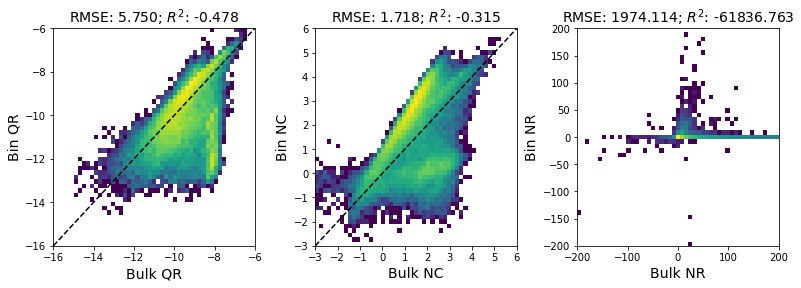

In [96]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
plt.subplots_adjust(wspace=0.3)
axes[0].hist2d(transformed_out_test["qrtend_MG2"], 
               transformed_out_test["qrtend_TAU"],
               cmin=1, bins=all_bins[0], norm=LogNorm())
axes[0].set_xlabel("Bulk QR", fontsize=14)
axes[0].set_ylabel("Bin QR", fontsize=14)
axes[1].set_xticks(np.arange(-16, 7))
axes[1].set_yticks(np.arange(-16, 7))
axes[0].plot(np.arange(-16, 7),np.arange(-16, 7), 'k--')
axes[0].set_title("RMSE: {0:0.3f}; $R^2$: {1:0.3f}".format(rmses_bulk[0], r2s_bulk[0]), fontsize=14)
axes[1].hist2d(transformed_out_test["nctend_MG2"], 
               transformed_out_test["nctend_TAU"],
               cmin=1, bins=all_bins[1], norm=LogNorm())
axes[1].set_xlabel("Bulk NC", fontsize=14)
axes[1].set_ylabel("Bin NC", fontsize=14)
axes[1].set_title("RMSE: {0:0.3f}; $R^2$: {1:0.3f}".format(rmses_bulk[1], r2s_bulk[1]), fontsize=14)
axes[1].set_xticks(np.arange(-3, 7))
axes[1].set_yticks(np.arange(-3, 7))
axes[1].plot(np.arange(-3, 7),np.arange(-3, 7), 'k--')
axes[2].hist2d(inverse_nr(labels_test["nrtend_MG2"], transformed_out_test["nrtend_MG2"]), 
               inverse_nr(labels_test["nrtend_TAU"], transformed_out_test["nrtend_TAU"]),
               cmin=1, bins=all_bins[2], norm=LogNorm())
axes[2].set_xlabel("Bulk NR", fontsize=14)
axes[2].set_ylabel("Bin NR", fontsize=14)
axes[2].set_title("RMSE: {0:0.3f}; $R^2$: {1:0.3f}".format(rmses_bulk[2], r2s_bulk[2]), fontsize=14)
#axes[2].set_xticks(np.arange(-400, 500, 100))
#axes[2].set_yticks(np.arange(-400, 500, 100))
#axes[2].plot(np.arange(-400, 500, 100),np.arange(-400, 500, 100), 'k--')
plt.savefig("nn_bulk_hist2d.png", dpi=200, bbox_inches="tight")